### Import niezbędnych bibliotek

In [ ]:
import datetime
import math
import os

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector
from tensorflow.keras.utils import Sequence

import cv2
import PIL

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

### Funkcje pomocnicze związane z przetwarzaniem i wyświetlaniem obrazów

In [ ]:
INPUT_SHAPE = (80, 80)


def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))


def process_img(img):
  img = cv2.resize(img, INPUT_SHAPE)
  return img

### Pobranie zbioru danych pochodzącego z platformy kaggle

In [ ]:
!kaggle datasets download -d dadajonjurakuziev/movieposter

In [ ]:
!unzip movieposter.zip

W celu prowadzenia prac zdecydowano się na wykorzystanie zbioru danych "movieposter", który jest wieloetykietowym zbiorem danych.

Zbiór zawiera 37235 unikalnych rekordów, na które składa się tytuł filmu, plakat w postaci pliku w formacie `.jpg` oraz informacje o przypisanych etykietach.

Zbiór danych wyróżnia 13 różnych etykiet opisujących kategorię filmu.

In [ ]:
# Data
data_labels = pd.read_csv('duplicate_free_41K.csv')
data_labels.head()

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,short,thriller
0,0,https://m.media-amazon.com/images/M/MV5BNDM0ND...,Construction,2021,7.4,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,0
1,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,1,0
3,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,1,0
4,4,https://m.media-amazon.com/images/M/MV5BOGI0Nz...,Asalu Em Jarigindhante,2020,10.0,drama,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# dropping all duplicate values
print(f'Duplicate length: {len(data_labels)}')
data_labels.drop_duplicates(subset="title", keep=False, inplace=True)
len_data = len(data_labels)
print(f'Data length: {len_data}')


Duplicate length: 41979
Data length: 37235


In [ ]:
# load images
idxs = data_labels.id

ll = data_labels['action'].astype(str)
for col in data_labels.columns[7:]:
    ll += data_labels[col].astype(str)

dataset_labels = ll
dataset_images = []

for idx in idxs:
    img = cv2.imread(f"img_41K/img_41K/{idx}.jpg")
    img = process_img(img)
    dataset_images.append(img)

Przykładowe plakaty pochodzące ze zbioru danych.

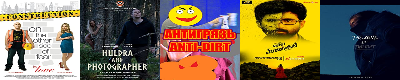

In [ ]:
imshow(np.concatenate(dataset_images[:5], 1))

In [ ]:
dataset_labels = dataset_labels.apply(lambda x : int(x))
ds = tf.data.Dataset.from_tensor_slices((np.array(dataset_images), np.array(dataset_labels)))

In [ ]:
DATASET_SIZE = len(ds)
DATASET_SIZE

37235

Zbiór danych podzielony został na zbiór treningowy, walidacyjny oraz testowy. Zbiór testowy wykorzystywany zostanie do porównania wyników algorytmów.

In [ ]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

ds = ds.shuffle(buffer_size=1000)
train_dataset = ds.take(train_size)
_ = ds.skip(train_size)
val_dataset = ds.take(val_size)
test_dataset = ds.take(test_size)

Jako podstawową wersję algorytmów wykorzystano kod z zajęć.

In [ ]:
rn50 = tf.keras.applications.resnet.ResNet50(
    weights="imagenet", input_shape=INPUT_SHAPE + (3,), include_top=False
)

flatten = tf.keras.layers.Flatten()(rn50.output)
dense1 = tf.keras.layers.Dense(512, activation="relu")(flatten)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(384, activation="relu")(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)
dense3 = tf.keras.layers.Dense(256, activation="relu")(dense2)
dense3 = tf.keras.layers.BatchNormalization()(dense3)
output = tf.keras.layers.Dense(128)(dense3)

embedding = tf.keras.Model(rn50.input, output)

trainable = False
for layer in rn50.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
def find_triplets_mask(indices_diff, labels_diff):
    triplets_indices = indices_diff[:, :, tf.newaxis] & \
                        indices_diff[:, tf.newaxis, :] & \
                        indices_diff[tf.newaxis, :, :]
    triplets_labels = ~labels_diff[:, :, tf.newaxis] & \
                      labels_diff[:, tf.newaxis, :]
    return triplets_labels & triplets_indices


def find_triplets_hard_negative_mask(triplets_mask, distances):
    loss = distances[:, :, tf.newaxis] - distances[:, tf.newaxis, :]
    loss = loss + tf.cast((~triplets_mask), tf.float32) * -1e9
    hardest = tf.reduce_max(loss, -1, keepdims=True)
    return (loss == hardest) & triplets_mask


def get_triplets_loss(triplets_mask, distances, triplets_margin=1.0):
    loss = distances[:, :, tf.newaxis] - distances[:, tf.newaxis, :]
    loss = tf.boolean_mask(loss, triplets_mask)
    loss = tf.nn.relu(loss + triplets_margin)
    return tf.math.divide_no_nan(tf.reduce_sum(loss), tf.reduce_sum(tf.cast(loss > 0, tf.float32)))

In [ ]:
class TripletsLoss(tf.keras.losses.Loss):
    def __init__(self, reduction=tf.keras.losses.Reduction.AUTO, name=None, triplets_margin=1.0):
        super().__init__(reduction=reduction, name=name)
        self.triplets_margin = triplets_margin

    def call(self, y_true, y_pred):
        if len(tf.shape(y_true)) == 2:
            y_true = tf.squeeze(y_true, -1)

        batch_size = tf.shape(y_true)[0]

        indices_diff = ~tf.eye(batch_size, dtype=tf.bool)
        labels_diff = y_true[:, tf.newaxis] != y_true[tf.newaxis]

        dot_prod = tf.matmul(y_pred, y_pred, transpose_b=True)
        square = tf.linalg.diag_part(dot_prod)

        distances = square[tf.newaxis] - 2.0 * dot_prod + square[:, tf.newaxis]
        distances = tf.maximum(distances, 0.0)

        t_mask = find_triplets_mask(indices_diff, labels_diff)
        t_mask_hard = find_triplets_hard_negative_mask(t_mask, distances)

        return get_triplets_loss(t_mask_hard, distances, self.triplets_margin)

In [ ]:
NUM_OF_EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
_ds_train = train_dataset.batch(BATCH_SIZE).prefetch(8)
_ds_val = val_dataset.batch(BATCH_SIZE).prefetch(8)
_ds_test = test_dataset.batch(BATCH_SIZE).prefetch(8)


In [ ]:
log_dir = "logs/triplet_1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

model = embedding
model.compile(
    optimizer=tf.optimizers.Adam(0.0001),
    loss=TripletsLoss(),
    metrics=[
             tf.keras.metrics.RootMeanSquaredError(),
             tf.keras.metrics.MeanSquaredLogarithmicError(),
             tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.BinaryAccuracy(),
             ]
)

model.fit(
    _ds_train,
    epochs=NUM_OF_EPOCHS,
    validation_data=_ds_val,
)

Epoch 1/20
815/815 [==============================] - 87s 96ms/step - loss: 54.2231 - root_mean_squared_error: 497454809088.0000 - mean_squared_logarithmic_error: 423.0627 - mean_absolute_error: 245907243008.0000 - binary_accuracy: 0.0070 - val_loss: 46.6046 - val_root_mean_squared_error: 453357371392.0000 - val_mean_squared_logarithmic_error: 392.5325 - val_mean_absolute_error: 205070073856.0000 - val_binary_accuracy: 0.0101
Epoch 2/20
815/815 [==============================] - 74s 91ms/step - loss: 16.1358 - root_mean_squared_error: 496848601088.0000 - mean_squared_logarithmic_error: 426.3857 - mean_absolute_error: 245359968256.0000 - binary_accuracy: 0.0036 - val_loss: 14.5162 - val_root_mean_squared_error: 450987687936.0000 - val_mean_squared_logarithmic_error: 395.0964 - val_mean_absolute_error: 202964992000.0000 - val_binary_accuracy: 0.0038
Epoch 3/20
815/815 [==============================] - 74s 91ms/step - loss: 6.0381 - root_mean_squared_error: 498288558080.0000 - mean_squar

Testy dla standardowej implementacji

In [ ]:
def get_embeddings(ds__, embedding_model):
  X = []
  y = []
  for batch in ds__:
    e_ = embedding_model.predict(batch[0])
    X += list(e_)
    y += list(batch[1])
  return X, y

X_train, y_train = get_embeddings(_ds_train, model)
X_test, y_test = get_embeddings(_ds_test, model)

from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

def parse_class(c):
    str_class = str(c)
    to_add = 13 - len(str_class)
    c2 = "".join([str(0) for _ in range(to_add)])
    parsed = c2 + str_class
    return [x for x in parsed]


In [ ]:
def calculate_scores(y_true, y_pred):

    true = [parse_class(i.numpy()) for i in y_true]
    true = np.array(true, dtype=int)

    pred = [parse_class(i) for i in y_pred]
    pred = np.array(pred, dtype=int)

    from sklearn.metrics import multilabel_confusion_matrix
    
    results = multilabel_confusion_matrix(true, pred)
  
    # MACRO
    recalls = []
    precisions = []
    f1s = []
    accuracies = []
    for idx, result in enumerate(results):
        tp = result[1,1]
        tn = result[0,0]
        fp = result[0,1]
        fn = result[1,0]
    
        if tp + fp + fn == 0 or tp == 0:
            recalls.append(0.0)
            precisions.append(0.0)
            f1s.append(0.0)
        else:
            recalls.append(tp / (tp + fn))
            precisions.append(tp / (tp + fp))
            f1s.append(2 * tp / (2 * tp + fp + fn))
        accuracies.append((tp + tn) / (tp + tn + fp + fn))

    macro_recall = sum(recalls) / len(recalls)
    macro_precision = sum(precisions) / len(precisions)
    macro_f1 = sum(f1s) / len(f1s)
    macro_accuracy = sum(accuracies) / len(accuracies)
    
    # MICRO
    tp, fn, fp = 0.0, 0.0, 0.0
    for idx, result in enumerate(results):
        tp += result[1,1]
        fp += result[0,1]
        fn += result[1,0]
    micro_recall = tp / (tp + fn)
    micro_precision = tp / (tp + fp)
    micro_f1 = 2 * tp / (2 * tp + fp + fn)
    micro_accuracy = (tp + tn) / (tp + tn + fp + fn)

    # WEIGHTED SUPPORT
    supports = np.array([sum(x) for x in zip(*true)], dtype=float)
    weighted_recall = sum(recalls * supports) / sum(supports)
    weighted_precision = sum(precisions * supports) / sum(supports)
    weighted_f1 = sum(f1s * supports) / sum(supports)
    weighted_accuracy = sum(accuracies * supports) / sum(supports)
    
    print('RECALL')
    print(f'MACRO: {macro_recall}, MICRO: {micro_recall}, WEIGHTED: {weighted_recall}')
    print('PRECISION')
    print(f'MACRO: {macro_precision}, MICRO: {micro_precision}, WEIGHTED: {weighted_precision}')
    print('F1 score')
    print(f'MACRO: {macro_f1}, MICRO: {micro_f1}, WEIGHTED: {weighted_f1}')
    print('Accuracy')
    print(f'MACRO: {macro_accuracy}, MICRO: {micro_accuracy}, WEIGHTED: {weighted_accuracy}')


calculate_scores(y_test, y_pred)

RECALL
MACRO: 0.17341963074797917, MICRO: 0.16592007026789635, WEIGHTED: 0.16592007026789635
PRECISION
MACRO: 0.45687905779571075, MICRO: 0.27596785975164356, WEIGHTED: 0.4876783352875485
F1 score
MACRO: 0.18801178127227416, MICRO: 0.20724081184860121, WEIGHTED: 0.18395167845953295
Accuracy
MACRO: 0.800950347772192, MICRO: 0.29990795911446977, WEIGHTED: 0.7594021567117205


#### WYNIKI DLA PODSTAWOWEJ METODY

epoch: 20; lr: 0.0001; batch size: 32; optim: Adam

Averaging method | Recall score | Precision score | F1 score | Accuracy
--- | --- | --- | --- | ---
Macro | 0.15403293854634567 | 0.42969856422286407 | 0.15705465554836034 | 0.7971765029956615
Micro | 0.14191273688849715 | 0.24390243902439024 | 0.17942717040008915 | 0.2873941446890878
Weighted | 0.14191273688849715 | 0.4572834937534294 | 0.1459919493054978 | 0.7544554469509046

### Eksperyment

Generowanie trójek/czwórek ze zmniejszającym się pokryciem etykiet.

In [ ]:
class DatasetSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, n, generator):
        self.x_set, self.y_set = x_set, y_set
        self.batch_size = batch_size
        self.n = n
        self.generator = generator
        self.epoch = 0
        self.x, self.y = self.generator(self.x_set, self.y_set)

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        # batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array(batch_x)

    def on_epoch_end(self):
        self.epoch += 1

        if self.epoch % self.n == 0:
            self.x, self.y = self.generator(self.x_set, self.y_set)

import numpy as np


class SimilarityGenerator:
    def __init__(self, k, num_of_samples, num_of_classes, n):
        self.k = k
        self.num_of_samples = num_of_samples
        self.num_of_classes = num_of_classes
        self.counter = 0
        self.n = n
        
    def parse_class(self, c):
        str_class = str(c)
        to_add = self.num_of_classes - len(str_class)
        c2 = "".join([str(0) for _ in range(to_add)])
        parsed = c2 + str_class
        return list(parsed)

    def __call__(self, x_set, y_set, *args, **kwargs):
        cls_dict = {}
        x = []
        y = []
        
        sim_class = (round(self.counter / self.n * (self.num_of_classes - 1)) + 1 ) / self.num_of_classes
        sim_class *= (1 - 1 / self.num_of_classes)

        for x_, y_ in zip(x_set, y_set):
            if cls_dict.get(y_) is None:
                cls_dict[y_] = []
            cls_dict[y_].append(x_)

        classes = list(cls_dict.keys())
        temp_classes = []
        for cl in classes:
          if len(cls_dict[cl]) == 1:
            del cls_dict[cl]
          else:
            temp_classes.append(cl)
        classes = temp_classes
        parsed_classes = [self.parse_class(cl) for cl in classes]

        for _ in range(self.k):
            import copy
            classes_copy = copy.deepcopy(classes)

            sample_classes = []
            anchor_class = random.sample(classes_copy, 1)[0]
            sample_classes.append(anchor_class)
            parsed_anchor = self.parse_class(anchor_class)
            for cl1, parsed_cl1 in zip(classes_copy, parsed_classes):
              sim = sum(np.array(parsed_cl1) == np.array(parsed_anchor)) / len(parsed_anchor)
              if sim < sim_class or sim == 1:
                  classes_copy.remove(cl1)
            if len(classes_copy) <= 1:
                classes_copy = copy.deepcopy(classes)

            for _ in range(self.num_of_samples - 2):
              rc = random.sample(classes_copy, 1)
              classes_copy.remove(rc[0])
              sample_classes.append(rc[0])

            sample_classes = random.sample(classes, self.num_of_samples - 1)
            sample = []
            temps = random.sample(cls_dict[sample_classes[0]], 2)

            for temp in temps:
                sample.append(tf.convert_to_tensor(temp))
            for i in range(1, self.num_of_samples - 1):
                sample.append(tf.convert_to_tensor(random.sample(cls_dict[sample_classes[i]], 1)[0]))
            x.append(sample)
            y.append([sample_classes[0]] + sample_classes)        
        self.counter += 1
        
        return x, y

train_generator = SimilarityGenerator(10000, 3, 13, 10)
train_dataset_seq = DatasetSequence(np.array(dataset_images[:train_size]), np.array(dataset_labels[:train_size]), BATCH_SIZE, NUM_OF_EPOCHS, train_generator)
val_generator = SimilarityGenerator(1000, 3, 13, 10)
val_dataset_seq = DatasetSequence(np.array(dataset_images[train_size:train_size+val_size]), np.array(dataset_labels[train_size:train_size+val_size]), BATCH_SIZE, NUM_OF_EPOCHS, val_generator)

In [ ]:
rn50 = tf.keras.applications.resnet.ResNet50(
    weights="imagenet", input_shape=INPUT_SHAPE + (3,), include_top=False
)

flatten = tf.keras.layers.Flatten()(rn50.output)
dense1 = tf.keras.layers.Dense(512, activation="relu")(flatten)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(384, activation="relu")(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)
dense3 = tf.keras.layers.Dense(256, activation="relu")(dense2)
dense3 = tf.keras.layers.BatchNormalization()(dense3)
output = tf.keras.layers.Dense(128)(dense3)

embedding = tf.keras.Model(rn50.input, output)

trainable = False
for layer in rn50.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

class Distance(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_layer_input = tf.keras.layers.Input(shape=INPUT_SHAPE + (3,))
positive_layer_input = tf.keras.layers.Input(shape=INPUT_SHAPE + (3,))
negative_layer_input = tf.keras.layers.Input(shape=INPUT_SHAPE + (3,))

distances = Distance()(
    embedding(tf.keras.applications.resnet.preprocess_input(anchor_layer_input)),
    embedding(tf.keras.applications.resnet.preprocess_input(positive_layer_input)),
    embedding(tf.keras.applications.resnet.preprocess_input(negative_layer_input)),
)

network = tf.keras.Model(
    inputs=(anchor_layer_input, positive_layer_input, negative_layer_input), outputs=distances
)

class Model(tf.keras.Model):
    def __init__(self, network, margin=0.5):
        super(Model, self).__init__()
        self.network = network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        tf.transpose(inputs, perm=[1,0,2,3,4]).shape
        return self.network((inputs[0], inputs[1], inputs[2]))

    def train_step(self, data):
        tf.transpose(data, perm=[1,0,2,3,4])
        data = (data[0], data[1], data[2])
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        loss_result = self.loss_tracker.result()
        return {"loss": loss_result}

    def test_step(self, data):
        tf.transpose(data, perm=[1,0,2,3,4])
        data = (data[0], data[1], data[2])

        loss = self._compute_loss(data)
        loss_result = self.loss_tracker.result()
        return {"loss": loss_result}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property  
    def metrics(self):
        return [self.loss_tracker]

model = Model(network)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), run_eagerly=True)
model.fit(train_dataset_seq, epochs=NUM_OF_EPOCHS, validation_data=val_dataset_seq)

Epoch 1/20
313/313 [==============================] - 186s 594ms/step - loss: 5.1912 - val_loss: 0.0000e+00
Epoch 2/20
313/313 [==============================] - 148s 474ms/step - loss: 0.4140 - val_loss: 0.0000e+00
Epoch 3/20
313/313 [==============================] - 147s 470ms/step - loss: 0.1804 - val_loss: 0.0000e+00
Epoch 4/20
313/313 [==============================] - 147s 470ms/step - loss: 0.1288 - val_loss: 0.0000e+00
Epoch 5/20
313/313 [==============================] - 147s 471ms/step - loss: 0.1934 - val_loss: 0.0000e+00
Epoch 6/20
313/313 [==============================] - 146s 468ms/step - loss: 0.2686 - val_loss: 0.0000e+00
Epoch 7/20
313/313 [==============================] - 146s 465ms/step - loss: 0.1631 - val_loss: 0.0000e+00
Epoch 8/20
313/313 [==============================] - 145s 465ms/step - loss: 0.0673 - val_loss: 0.0000e+00
Epoch 9/20
313/313 [==============================] - 145s 464ms/step - loss: 0.0784 - val_loss: 0.0000e+00
Epoch 10/20
313/313 [=======

In [ ]:
def get_embeddings(ds__, embedding_model):
  X = []
  y = []
  for batch in ds__:
    e_ = embedding_model.predict(batch[0])
    X += list(e_)
    y += list(batch[1])
  return X, y

X_train, y_train = get_embeddings(_ds_train, embedding)
X_test, y_test = get_embeddings(_ds_test, embedding)

from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(sum(y_pred == y_test) / len(y_pred))
print(calculate_scores(y_test, y_pred))

def parse_class(c):
    str_class = str(c)
    to_add = 13 - len(str_class)
    c2 = "".join([str(0) for _ in range(to_add)])
    parsed = c2 + str_class
    return [x for x in parsed]


#### WYNIKI DLA NASZEGO PODEJŚCIA

Averaging method | Recall score | Precision score | F1 score | Accuracy
--- | --- | --- | --- | ---
Macro | 0.31791180889897075 | 0.43889502471039665 | 0.31947799074362976 | 0.8224226981612837
Micro | 0.33986813186813186 | 0.417945945945946 | 0.3748848484848485 | 0.36702832736020424
Weighted | 0.33986813186813186 | 0.4799305915055798 | 0.3527219295096308 | 0.7876774326836995
